## Toy MHD and divergence cleaning 


We made a code to check the divergence cleaning strategies discussed in: https://www.overleaf.com/read/phmtkqtkxwjr#baf932

In [1]:
using Plots
using SummationByPartsOperators
using LinearAlgebra
using ArraysOfArrays
using Base.Threads
using Revise
using JLD2

includet("../Julia/PIC/PIC-1D/aux_functions/aux_functions_grid.jl")
includet("../Julia/PIC/PIC-1D/aux_functions/aux_functions_E-B.jl")
includet("../Julia/PIC/PIC-1D/aux_functions/aux_functions_RHS.jl")

In [2]:
J = (100,100)
Box = (0.0,1.0,0.0,1.0)
dx = differentials(Box,J)
const D = 2

xv = [(i-1)*dx[1] for i in 1:J[1]]
yv = [(i-1)*dx[2] for i in 1:J[2]];

In [3]:
Dx = periodic_derivative_operator(derivative_order=1, accuracy_order=6, xmin=Box[1], xmax=Box[2], N=J[1])
Dy = periodic_derivative_operator(derivative_order=1, accuracy_order=6, xmin=Box[3], xmax=Box[4], N=J[2])
Δx = dissipation_operator(Dx;
                     #mode=D.coefficients.mode
                     #,mode=ThreadedMode()
                     )
Δy = dissipation_operator(Dy;
                     #mode=D.coefficients.mode
                     #,mode=ThreadedMode()
                     )
σx = 0.0 #dissipation strength
σy = 0.0 #dissipation strength

0.0

Build initial data and velocity field.

In [154]:
k1 = 2π*[1,1]
k2 = 2π*[2,2]
x0 = [0.5,0.5]
fv(x,y,k) = sin(k[1]*x)*sin(k[2]*y)
function fp(x,y,x0,p) 
    r20 = 0.02
    r2 = (x-x0[1])^2+(y-x0[2])^2
    if r2 - r20 < 0
        return (r2 - r20)^p/r20^p
    else
        return 0.0
    end
end
V = [-(l-2)*sin(k1[1]*xv[i]) + (l-1)*sin(k1[2]*yv[j]) for l in 1:2, i in 1:J[1], j in 1:J[2]];
B = [(l-2)*k2[2]*sin(k2[1]*xv[i])*cos(k2[2]*yv[j]) + (l-1)*k2[1]*cos(k2[1]*xv[i])*sin(k2[2]*yv[j]) for l in 1:2, i in 1:J[1], j in 1:J[2]];


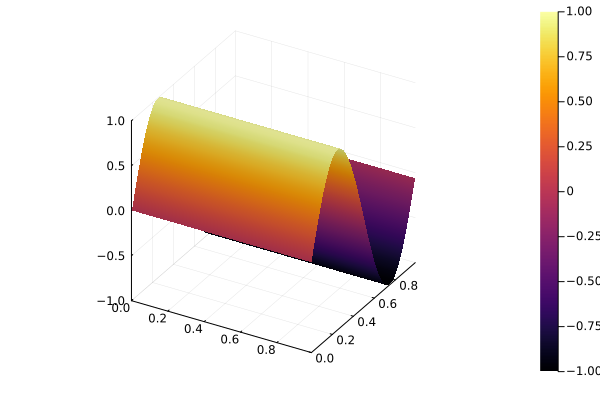

In [34]:
surface(yv,xv,V[1,:,:])

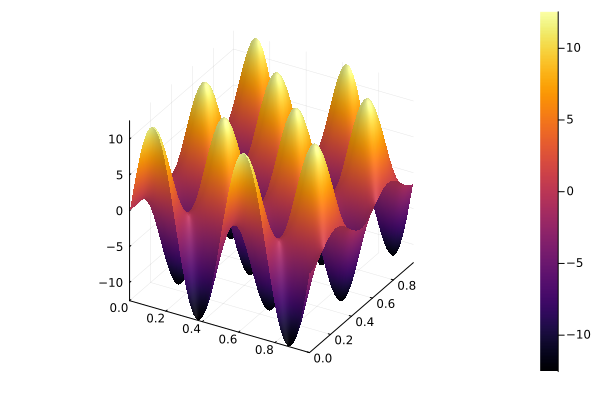

In [6]:
surface(yv,xv,B[2,:,:])

In [7]:
function Div(B,Dx,Dy,J) 
    div = zeros(J[1],J[2])
    @threads for j in 1:J[2]
        div[:,j] .+= Dx*B[1,:,j]
    end
    @threads for i in 1:J[1]
        div[i,:] .+= Dy*B[2,i,:]
    end
    return div
end 

Div (generic function with 1 method)

In [49]:
@show maximum(abs.(Div(B,Dx,Dy,J)))

maximum(abs.(Div(B, Dx, Dy, J))) = 2.2453150450019166e-12


2.2453150450019166e-12

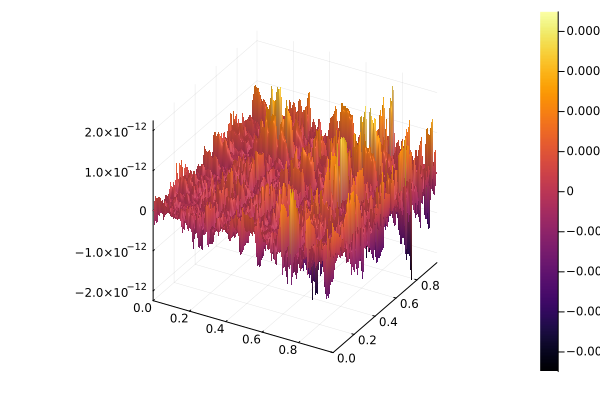

In [8]:
surface(yv,xv,Div(B,Dx,Dy,J))

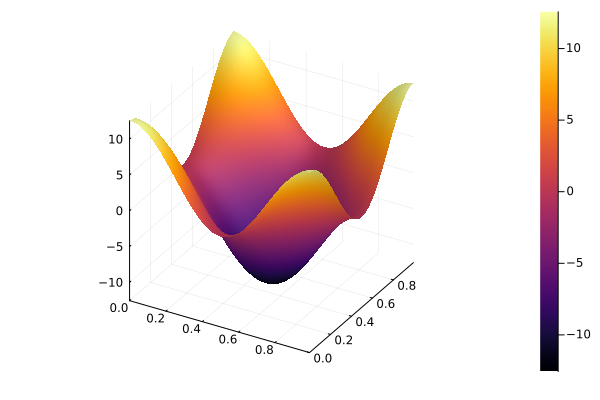

In [9]:
surface(yv,xv,Div(V,Dx,Dy,J))

In [155]:
u = Vector{Float64}(undef,D*J[1]*J[2]);
du = Vector{Float64}(undef,D*J[1]*J[2]);

u .= 0.0;
du .= 0.0;

#F = reshape(u,D,J[1],J[2]);



#F = B


20000-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

The evolution equations are:

$$
\partial_t B^i = \nabla_j (v^j B^i - v^i B^j) + \kappa \nabla^i (\nabla_j B^j)
$$

In [143]:
function F!(u, t, par)
    J, Dx, Δx, Dy, Δy, σx, σy, V, κ, du = par
    du .=0.0
    u_a = reshape(u,(D,J...))
    Du_a = reshape(du,(D,J...))
    div = zeros(J...)

    #first the divergence cleaning term
    @threads for j in 1:J[2]
        mul!(view(div,:,j), Dx, view(u_a,1,:,j))
    end
    @threads for i in 1:J[1]
        mul!(view(div,i,:), Dy, view(u_a,2,i,:), one(eltype(u_a)), one(eltype(u_a)))
    end
    # the y derivative term 
    @threads for i in 1:J[1]
        mul!(view(Du_a,1,i,:), Dy, view(u_a,1,i,:).*V[2,i,:] - view(u_a,2,i,:).*V[1,i,:])
        mul!(view(Du_a,2,i,:), Dy, view(div,i,:), κ, zero(eltype(u_a)))
    end
    @threads for j in 1:J[2]
        mul!(view(Du_a,2,:,j), Dx , view(u_a,2,:,j).*V[1,:,j] - view(u_a,1,:,j).*V[2,:,j], one(eltype(u_a)), one(eltype(u_a)))
        mul!(view(Du_a,1,:,j), Dx , view(div,:,j), κ, one(eltype(u_a)))
    end
    #=
    @threads for i in 1:J[1]
        mul!(view(Du_a,1,i,:), Δy, view(u_a,1,i,:), σy, one(eltype(u_a)))
        mul!(view(Du_a,2,i,:), Δy, view(u_a,2,i,:), σy, one(eltype(u_a)))
    end
    @threads for j in 1:J[2]
        mul!(view(Du_a,1,:,j), Δx, view(u_a,1,:,j), σx, one(eltype(u_a)))
        mul!(view(Du_a,2,:,j), Δx, view(u_a,2,:,j), σx, one(eltype(u_a)))
    end
    =#
    return du[:]
end

F! (generic function with 1 method)

In [142]:
function Div2(B,Dx,Dy,J)
    div = zeros(J[1],J[2])
    @threads for j in 1:J[2]
        mul!(view(div,:,j), Dx, view(B,1,:,j))
    end
    @threads for i in 1:J[1]
        mul!(view(div,i,:), Dy, view(B,2,i,:), one(eltype(B)), one(eltype(B)))
    end
    return div[:,:]
end


Div2(B,Dx,Dy,J)

100×100 Matrix{Float64}:
  0.0           3.97904e-13   3.12639e-13  …   4.83169e-13   1.13687e-12
 -3.97904e-13   0.0          -1.42109e-13      1.13687e-13   6.53699e-13
 -3.12639e-13   1.13687e-13   0.0              2.55795e-13   7.95808e-13
 -3.97904e-13   2.84217e-14  -5.68434e-14      2.84217e-14   6.53699e-13
 -3.69482e-13   8.52651e-14  -1.13687e-13      1.13687e-13   6.53699e-13
 -1.98952e-13   4.26326e-14   4.26326e-14  …   2.13163e-13   6.25278e-13
 -2.84217e-13  -5.68434e-14  -5.68434e-14      7.10543e-14   4.68958e-13
 -8.52651e-14   1.13687e-13  -5.68434e-14      7.10543e-14   5.54223e-13
 -2.84217e-13   0.0          -4.26326e-14     -4.26326e-14   3.97904e-13
 -1.13687e-13   4.26326e-14  -2.84217e-14      1.98952e-13   3.41061e-13
  ⋮                                        ⋱                
 -4.26326e-14   8.52651e-14   4.26326e-14      2.27374e-13   3.83693e-13
 -4.40536e-13  -1.84741e-13  -3.83693e-13     -2.27374e-13   2.13163e-13
 -5.11591e-13  -1.98952e-13  -2.41585e

In [75]:
function get_Energy(u,J,Box)
    U_a = reshape(u,(D,J...))
    return norm(U_a)^2*volume(Box)/prod(J)
end

get_Energy (generic function with 1 method)

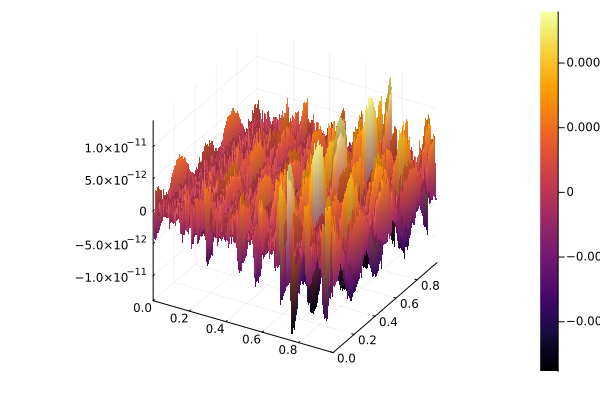

In [156]:
u = copy(vec(B));
@show B === reshape(u,(D,J...))
@show norm(B - reshape(u,(D,J...)))
@show maximum(abs.(u))
@show maximum(abs.(F))
@show get_Energy(u,J,Box)
@show maximum(abs.(Div(reshape(u,(D,J...)),Dx,Dy,J)))

@show typeof(u)
@show typeof(F!(u,0.0,(J, Dx, Δx, Dy, Δy, σx, σy, V, 0.1, du)))

surface(yv,xv,reshape(F!(u,0.0,(J, Dx, Δx, Dy, Δy, σx, σy, zeros(D,J...), 0.1, du)),D,J...)[2,:,:])
#surface(yv,xv,du[2,:,:])

In [157]:
(t_i, t_f) = (0.0, 200.0)
M = 40000
@show dt = (t_f - t_i)/M
@show differentials(Box,J)
κ = maximum(dx)
#κ = 100.0
@show κ 
par = (J, Dx, Δx, Dy, Δy, σx, σy, V, κ, du)
      #(J, Dx, Δx, Dy, Δy, σx, σy, V, 0.1, du)
t = t_i
Energy = Array{Float64,1}(undef,M+1)
Div_B = Array{Float64,1}(undef,M+1)
tt = Array{Float64,1}(undef,M+1)
@show Energy[1] = get_Energy(u,J,Box)
@show Div_B[1] = maximum(abs.(Div(reshape(u,(D,J...)),Dx,Dy,J)))
tt[1] = t

0.0

In [ ]:
for i in 1:M
    RK4_Step!(F!, u, 0.0, dt, par)
    t = t + dt
    tt[i+1] = t
    
    Energy[i+1] = get_Energy(u,J,Box)
    Div_B[i+1] = maximum(abs.(Div(reshape(u,(D,J...)),Dx,Dy,J)))

    println("t = $t")
    println("Energy = $(get_Energy(u,J,Box))")
    println("DivB = $(maximum(abs.(Div(reshape(u,(D,J...)),Dx,Dy,J))))")
    
end

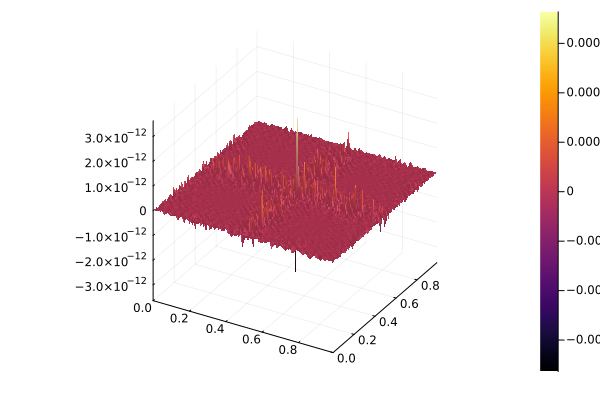

In [148]:
surface(yv,xv,Div(reshape(u,(D,J...)),Dx,Dy,J))

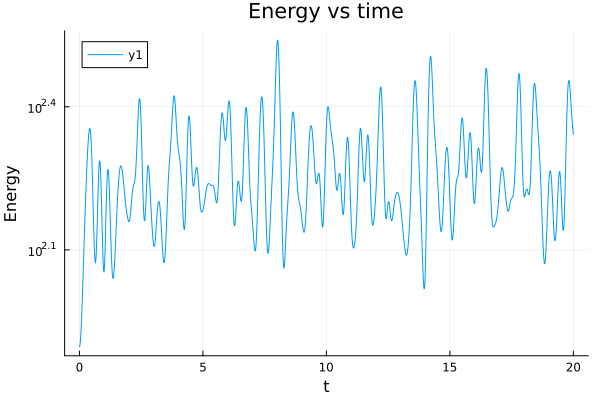

In [149]:
plot(tt,Energy,yscale=:log10,title="Energy vs time",xlabel="t",ylabel="Energy")

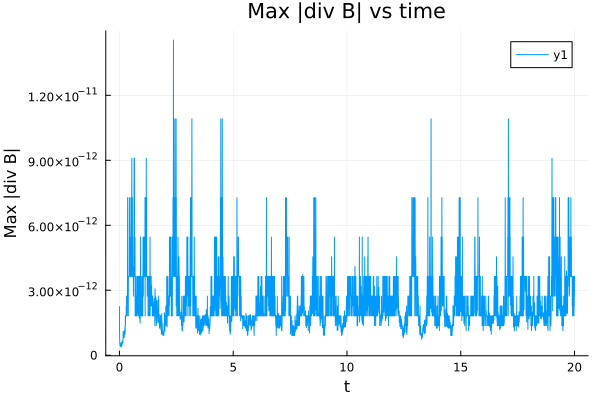

In [150]:
plot(tt,Div_B,title="Max |div B| vs time",xlabel="t",ylabel="Max |div B|")

In [151]:
#Div_B0 = copy(Div_B);
Div_Bκ = copy(Div_B);

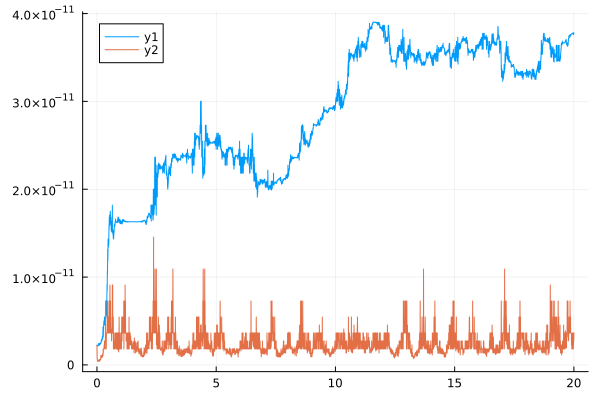

In [153]:
plot(tt,Div_B0)
plot!(tt,Div_Bκ)